In [12]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score
)
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

### READ DATA

In [13]:
train = pd.read_csv("./data/processed/train.csv")
test = pd.read_csv("./data/processed/test.csv")

X_train = train.drop(columns=["review_flagged"])
y_train = train["review_flagged"]

X_test = test.drop(columns=["review_flagged"])
y_test = test["review_flagged"]

# Replace inf and -inf with NaN
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test  = X_test.replace([np.inf, -np.inf], np.nan)

# Replace NaN with 0
X_train = X_train.fillna(0)
X_test  = X_test.fillna(0)


### Model Evaluation Helper Function

In [14]:
def evaluate_model(name, y_true, y_prob):
    """
    Evaluates a binary classifier using appropriate metrics.
    """
    y_pred = (y_prob >= 0.5).astype(int)

    results = {
        "Model": name,
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }
    return results

# CV object
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Baseline Model Training + Evaluation

In [40]:
# 3. BASELINE MODEL (predict prob = 0.5)
y_prob_baseline = np.full_like(y_test, 0.5, dtype=float)

baseline_result = evaluate_model("Baseline (0.5 prob)", y_test, y_prob_baseline)

### Logistic Regression with CV Grid Search + Evaluation

In [41]:
logreg_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

logreg_params = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__penalty": ["l2"],
    "clf__solver": ["lbfgs", "saga"]
}

logreg_grid = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=logreg_params,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

logreg_grid.fit(X_train, y_train)

y_prob_logreg = logreg_grid.predict_proba(X_test)[:, 1]

logreg_result = evaluate_model(
    f"Logistic Regression (GridSearchCV)",
    y_test, y_prob_logreg
)
logreg_result["Best Params"] = logreg_grid.best_params_
logreg_result["CV ROC-AUC"] = logreg_grid.best_score_

### XGBoost with CV Grid Search + Evaluation

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


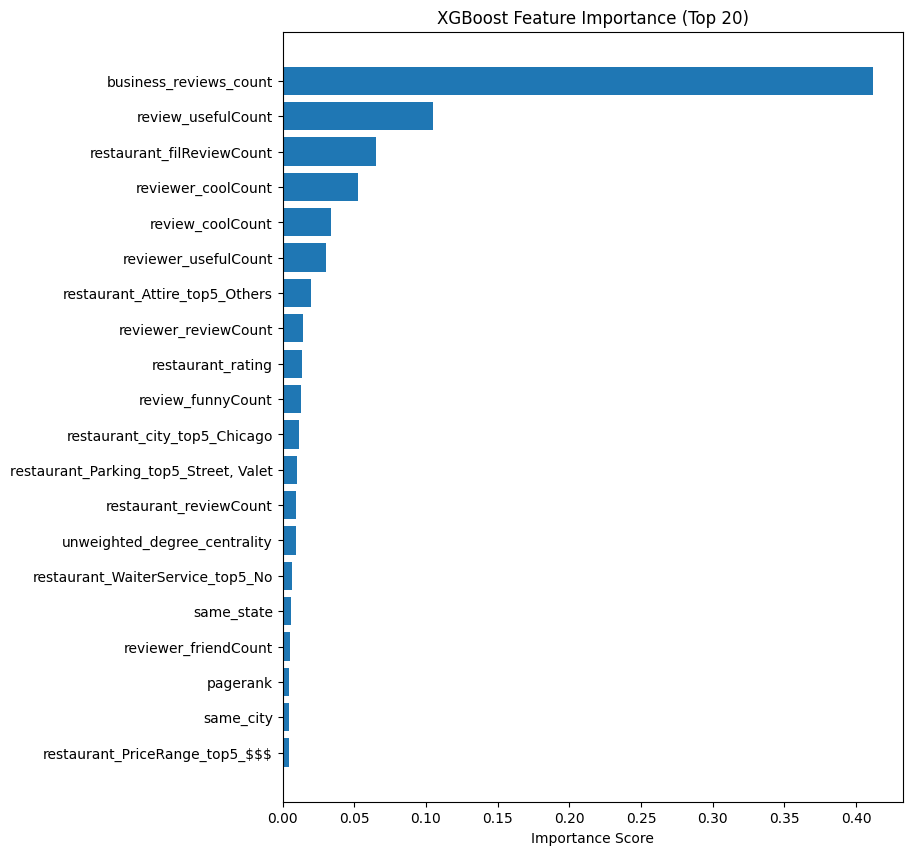

In [48]:
xgb_base = XGBClassifier(
    eval_metric="logloss",
    n_jobs=-1,
    tree_method="hist"
)

# Parameter grid 
xgb_params = {
    "n_estimators": [300, 500],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.03],
    "subsample": [0.7, 0.8],
    "colsample_bytree": [0.7, 0.8],
    "reg_alpha": [0, 0.1, 0.5],   
    "reg_lambda": [1, 2, 5]      
}

# Grid search 
xgb_grid = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_params,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit grid search on training data
xgb_grid.fit(X_train, y_train)

# Best model (refit=True by default)
best_xgb = xgb_grid.best_estimator_

# Predict on test data
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate model
xgb_result = evaluate_model(
    "XGBoost (GridSearchCV + Regularisation)",
    y_test, y_prob_xgb
)

xgb_result["Best Params"] = xgb_grid.best_params_
xgb_result["CV ROC-AUC"] = xgb_grid.best_score_

# Feature importance
xgb_importance = best_xgb.feature_importances_
feat_imp_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": xgb_importance
}).sort_values("importance", ascending=False)

feat_imp_df["feature"] = feat_imp_df["feature"].str.replace("$", "\\$")

plt.figure(figsize=(8, 10))
plt.barh(feat_imp_df.head(20)["feature"], feat_imp_df.head(20)["importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance (Top 20)")
plt.xlabel("Importance Score")
plt.show()

### NEURAL NETWORK (MLPClassifier) with CV Grid search + Evaluation

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict

param_grid = {
    "clf__hidden_layer_sizes": [
        (64, 32),
        (128, 64)
    ],
    "clf__learning_rate_init": [0.001, 0.0005],
    "clf__activation": ["relu", "tanh"],
    "clf__alpha": [0.0001, 0.001, 0.01],   
}


mlp_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(max_iter=200, random_state=42))
])

grid = GridSearchCV(
    estimator=mlp_pipeline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Best ROC-AUC:", grid.best_score_)
print("Best Params:", grid.best_params_)

best_mlp = grid.best_estimator_

mlp_cv_pred = cross_val_predict(
    best_mlp, X_train, y_train,
    cv=cv, method="predict_proba"
)[:, 1]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\Jayle\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best ROC-AUC: 0.9934091064253934
Best Params: {'clf__activation': 'relu', 'clf__alpha': 0.001, 'clf__hidden_layer_sizes': (64, 32), 'clf__learning_rate_init': 0.0005}


C:\Users\Jayle\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Jayle\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [16]:
# Train and evaluate the best model
best_mlp.fit(X_train, y_train)

y_prob_mlp = best_mlp.predict_proba(X_test)[:, 1]

mlp_result = evaluate_model("MLP (Tuned)", y_test, y_prob_mlp)
mlp_result["CV ROC-AUC"] = roc_auc_score(y_train, mlp_cv_pred)

C:\Users\Jayle\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Best Params MLPClassifier + Early Stopping

Using the best parameters identified earlier by the grid search, we now create a new model with the same parameters, with early stopping to avoid overfitting.

In [17]:
# Rebuild pipeline with early stopping, with the best parameters
mlp_es_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        learning_rate_init=0.0005,
        alpha=0.001,
        max_iter=300,            # allow enough iterations
        early_stopping=True,     # enable early stopping
        validation_fraction=0.1, # 10% of training used as validation
        n_iter_no_change=10,     # stop if no improvement for 10 epochs
        random_state=42
    ))
])

# Fit on full training data
mlp_es_pipeline.fit(X_train, y_train)

# Predict probabilities on test set
y_prob_mlp_es = mlp_es_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
mlp_es_result = evaluate_model("MLP (Rebuilt with EarlyStopping)", y_test, y_prob_mlp_es)

print("Rebuilt MLP with early stopping trained successfully!")

Rebuilt MLP with early stopping trained successfully!


### Plotting SHAP for MLPClassifier

SHAP allows us to have a greater understanding of which features are most important globally, and whhether high or low feature values increase/decreases predictions, giving us greater model interpretabilitiy. 

In [21]:
# Extract the MLP classifier from the pipeline
mlp_model = mlp_es_pipeline.named_steps['clf']

# Extract the scaled training data
X_train_scaled = mlp_es_pipeline.named_steps['scaler'].transform(X_train)

# Use a small subset as background for SHAP
background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

explainer = shap.KernelExplainer(mlp_model.predict_proba, background)

# Compute SHAP values for test set
X_test_scaled = mlp_es_pipeline.named_steps['scaler'].transform(X_test)
shap_values = explainer.shap_values(X_test_scaled)

  0%|          | 0/10000 [00:00<?, ?it/s]

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

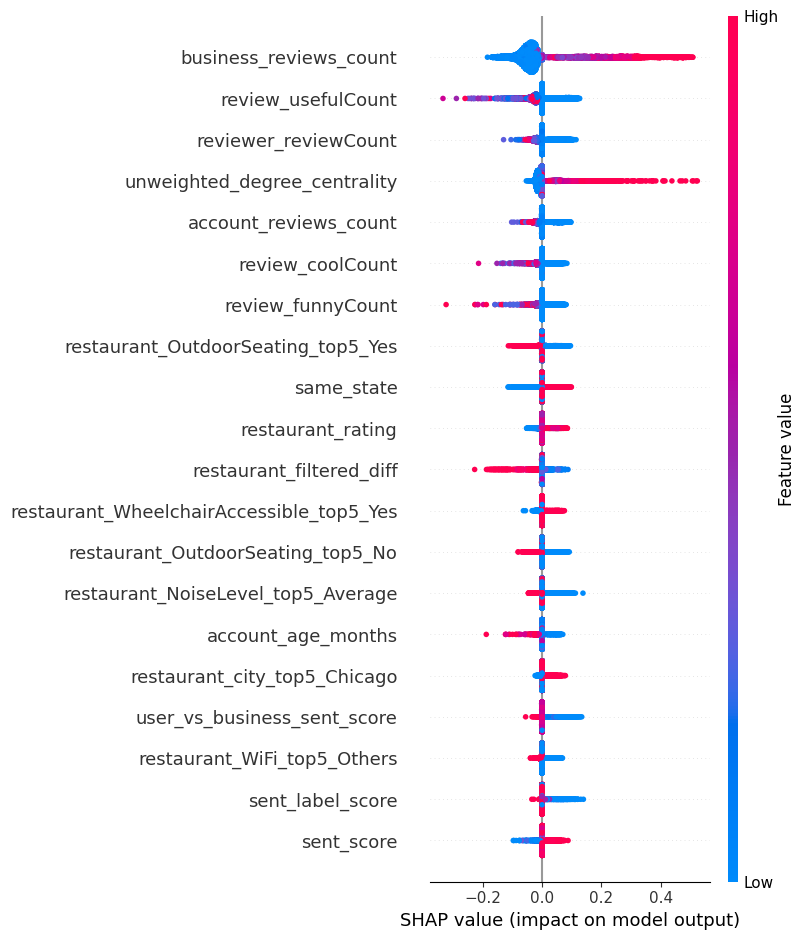

In [24]:
shap_class1 = shap_values[:, :, 1]   # shape = (n_samples, n_features)

shap.summary_plot(shap_class1, X_test_scaled, feature_names=X_train.columns)

In [26]:
import joblib

# Save the tuned, early stopping model
joblib.dump(mlp_es_pipeline, "models/best_mlp_es_pipeline_gridsearch.joblib")
joblib.dump(best_mlp, "models/best_mlp_gridsearch.joblib")
joblib.dump(best_xgb, "models/xgboost.joblib")
joblib.dump(logreg_grid, "models/log_reg.joblib")

['models/best_mlp_gridsearch.joblib']

### Model Evaluation On Test Data

In [28]:
# --- Load your saved models ---
mlp_es = joblib.load("models/best_mlp_es_pipeline_gridsearch.joblib")
mlp_best = joblib.load("models/best_mlp_gridsearch.joblib")
xgb_model = joblib.load("models/xgboost.joblib")
logreg_model = joblib.load("models/log_reg.joblib")

results = []

# Baseline model
results.append(evaluate_model("Baseline (0.5 prob)", y_test, y_prob_baseline))

# 1. Best MLPClassifier from GridSearchCV with EarlyStopping 
y_prob = mlp_es.predict_proba(X_test)[:, 1]
results.append(evaluate_model("MLP (EarlyStopping Pipeline)", y_test, y_prob))

# 2. Best MLPClassifier from GridSearchCV 
y_prob = mlp_best.predict_proba(X_test)[:, 1]
results.append(evaluate_model("MLP (Best GridSearch)", y_test, y_prob))

# 3. XGBoost 
y_prob = xgb_model.predict_proba(X_test)[:, 1]
results.append(evaluate_model("XGBoost", y_test, y_prob))

# 4. Logistic Regression
y_prob = logreg_model.predict_proba(X_test)[:, 1]
results.append(evaluate_model("Logistic Regression", y_test, y_prob))

# --- Convert to DataFrame for easier reading ---
results_df = pd.DataFrame(results)
results_df


C:\Users\Jayle\anaconda3\lib\pickle.py:1718: UserWarning: [17:31:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
C:\Users\Jayle\anaconda3\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jayle\anaconda3\lib\

,Model,ROC-AUC,Accuracy,Precision,Recall,F1
0,MLP (EarlyStopping Pipeline),0.994097,0.9728,0.898909,0.942203,0.920047
1,MLP (Best GridSearch),0.993112,0.9705,0.916972,0.904275,0.910579
2,XGBoost,0.997903,0.9845,0.929795,0.980734,0.954585
3,Logistic Regression,0.990813,0.9667,0.834004,0.998194,0.908742
